## IMPORTING PACKAGES

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import graphviz

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix




## PREPARING THE DATASETS

#### 0.Importing the Datasets

In [39]:
filename = "penguins.csv"
palmer_penguin = pd.read_csv(filename)
palmer_penguin.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


Remove missing values

In [40]:
palmer_penguin = palmer_penguin.dropna(axis="index", how="any")
palmer_penguin.head()
print(len(palmer_penguin))

333


### 1.Setting Up the Training and Test Datasets

We will split the original dataset into 4 different splitting strategies, with the proportion of traning and test as follows: 40/60, 60/40, 80/20, and 90/10.

First, we split the original dataset into feature and label columns, as the target we are considering now is 


In [41]:
palmer_penguin_feature = palmer_penguin.drop(columns = ['species'])
palmer_penguin_label = palmer_penguin['species']

Then the feature and label are split into 4 splitting strategies as mentioned above.

In [42]:
training_sizes = {
    "40/60": 0.4,
    "60/40": 0.6,
    "80/20": 0.8,
    "90/10": 0.9,
}

datasets = {}
for name, training_size in training_sizes.items():
    feature_train, feature_test, label_train, label_test = train_test_split(
        palmer_penguin_feature, palmer_penguin_label,
        test_size=(1 - training_size),
        shuffle=True,
        stratify=palmer_penguin_label
    )

    datasets[name] = (feature_train, feature_test, label_train, label_test)



#### Original Set

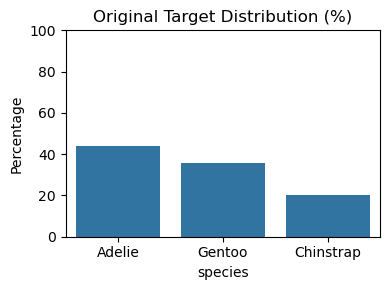

In [43]:

plt.figure(figsize=(4,3))
original_pct = palmer_penguin_label.value_counts(normalize=True) * 100
original_df = pd.DataFrame({
    'species': original_pct.index.astype(str),
    'Percentage': original_pct.values
})

sns.barplot(data=original_df, x='species', y='Percentage')
plt.title("Original Target Distribution (%)")
plt.ylim(0, 100)
plt.ylabel("Percentage")
plt.xlabel("species")
plt.tight_layout()
plt.show()

#### Training Set

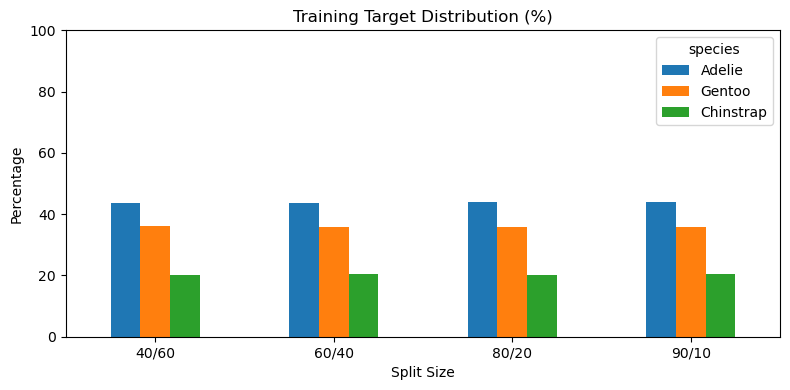

In [44]:
train_distributions = {}

for name, (feature_train, feature_test, label_train, label_test) in datasets.items():
    train_pct = label_train.value_counts(normalize=True) * 100
    train_distributions[name] = train_pct

train_df = pd.DataFrame(train_distributions).T

train_df.plot(kind='bar', figsize=(8, 4), legend=True)
plt.title("Training Target Distribution (%)")
plt.ylim(0, 100)
plt.ylabel("Percentage")
plt.xlabel("Split Size")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Test Set

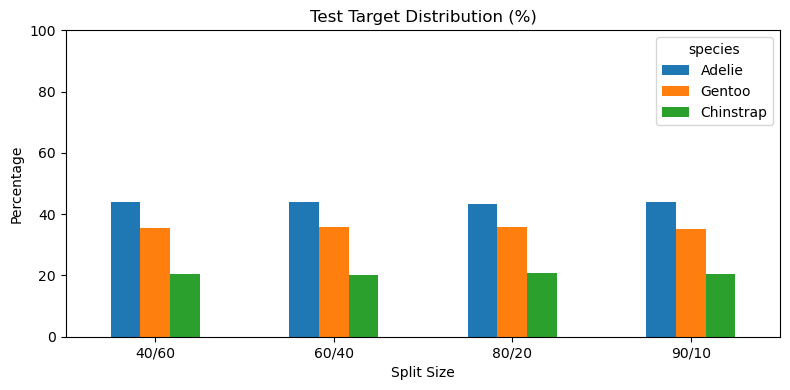

In [45]:
test_distributions = {}

for name, (feature_train, feature_test, label_train, label_test) in datasets.items():
    test_pct = label_test.value_counts(normalize=True) * 100
    test_distributions[name] = test_pct

test_df = pd.DataFrame(test_distributions).T

test_df.plot(kind='bar', figsize=(8, 4), legend=True)
plt.title("Test Target Distribution (%)")
plt.ylim(0, 100)
plt.ylabel("Percentage")
plt.xlabel("Split Size")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Categorical handling

In [46]:
column_transformer = ColumnTransformer(
    transformers=[("categorical", OneHotEncoder(drop="first", sparse_output=False), ['island', 'sex'])],
    remainder="passthrough"
)
label_encoder = LabelEncoder()
for name, (feature_train, feature_test, label_train, label_test) in datasets.items():
    feature_train = column_transformer.fit_transform(feature_train)
    feature_test = column_transformer.transform(feature_test)

    label_train = label_encoder.fit_transform(label_train)
    label_test = label_encoder.transform(label_test)

    datasets[name] = (feature_train, feature_test, label_train, label_test)


### 2. Building the Decision Tree Classifiers

In [47]:
models = {}
for name, (feature_train, feature_test, label_train, label_test) in datasets.items():
    model = tree.DecisionTreeClassifier(criterion = "entropy")
    model.fit(feature_train, label_train)
    models[name] = model

graphs = {}

for name, model in models.items():
    dot_data = tree.export_graphviz(
        model, 
        out_file=None,
        filled=True,
        rounded=True,
    )
    graph = graphviz.Source(dot_data)
    graphs[name] = graph


Decision Tree Graph for 40/60 splitting.


(process:19680): Pango-CRITICAL **: 22:46:04.626: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:19680): Pango-CRITICAL **: 22:46:04.626: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:19680): Pango-CRITICAL **: 22:46:04.626: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:19680): Pango-CRITICAL **: 22:46:04.626: pango_font_description_get_family: assertion 'desc != NULL' failed


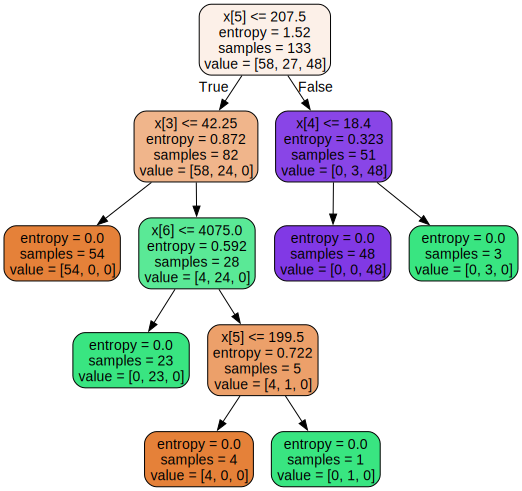

In [48]:
graphs['40/60']

Decision Tree Graph for 60/40 splitting.


(process:23256): Pango-CRITICAL **: 22:46:04.807: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:23256): Pango-CRITICAL **: 22:46:04.807: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:23256): Pango-CRITICAL **: 22:46:04.807: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:23256): Pango-CRITICAL **: 22:46:04.807: pango_font_description_get_family: assertion 'desc != NULL' failed


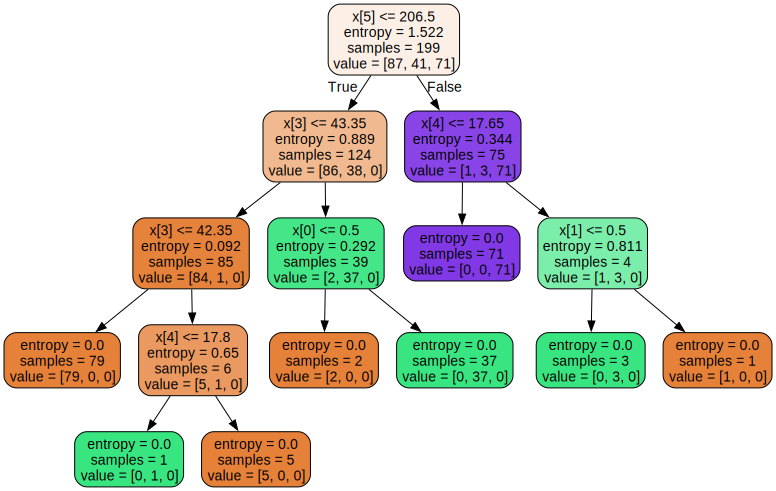

In [49]:
graphs['60/40']

Decision Tree Graph for 80/20 splitting.


(process:22772): Pango-CRITICAL **: 22:46:04.884: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:22772): Pango-CRITICAL **: 22:46:04.884: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:22772): Pango-CRITICAL **: 22:46:04.884: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:22772): Pango-CRITICAL **: 22:46:04.884: pango_font_description_get_family: assertion 'desc != NULL' failed


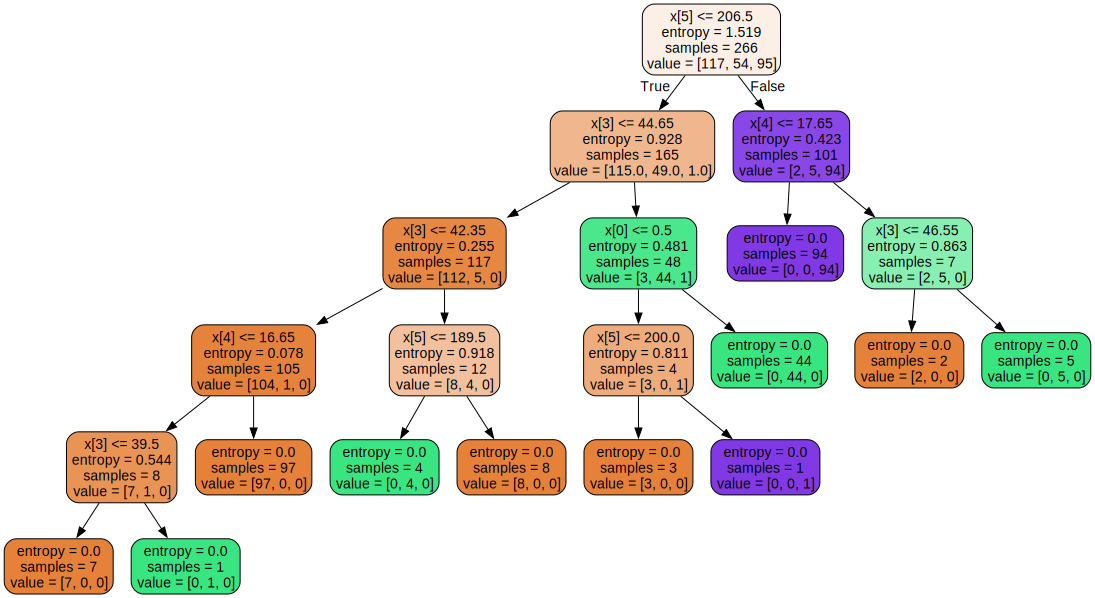

In [50]:
graphs['80/20']

Decision Tree Graph for 90/10 splitting.


(process:10540): Pango-CRITICAL **: 22:46:04.971: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:10540): Pango-CRITICAL **: 22:46:04.971: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:10540): Pango-CRITICAL **: 22:46:04.971: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:10540): Pango-CRITICAL **: 22:46:04.971: pango_font_description_get_family: assertion 'desc != NULL' failed


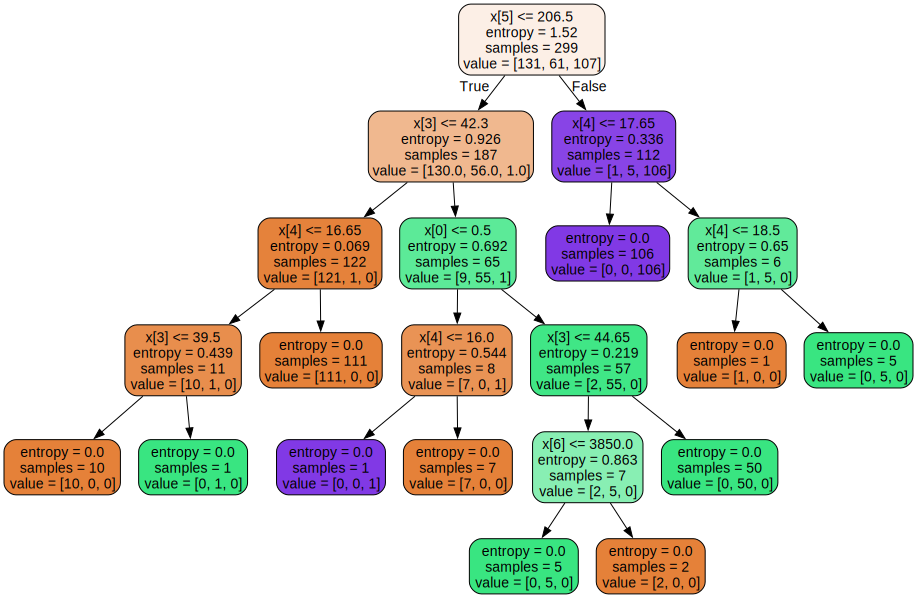

In [51]:
graphs["90/10"]

### 2. Evaluating the Decison Tree Classifiers

In [52]:
encoded_labels = [0, 1, 2]  
original_labels = label_encoder.inverse_transform(encoded_labels)

print(original_labels)

['Adelie' 'Chinstrap' 'Gentoo']


In [53]:

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
eval_results = {}
for name, model in models.items():
    feature_train, feature_test, label_train, label_test = datasets[name]
    y_pred = model.predict(feature_test)
    y_true = label_test
    report = classification_report(y_true, y_pred, labels=[0,1,2],   zero_division=1)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
     
    eval_results[name] = (report, cm)
    

In [54]:
def evaluate(training_size):
    print(eval_results[training_size][0])
    cm_display = ConfusionMatrixDisplay(eval_results[training_size][1], display_labels = original_labels)
    cm_display.plot(cmap = "Blues")
    plt.show()

#### a. 40/60 Splitting

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        88
           1       0.88      0.90      0.89        41
           2       0.99      0.97      0.98        71

    accuracy                           0.95       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.95      0.95      0.95       200



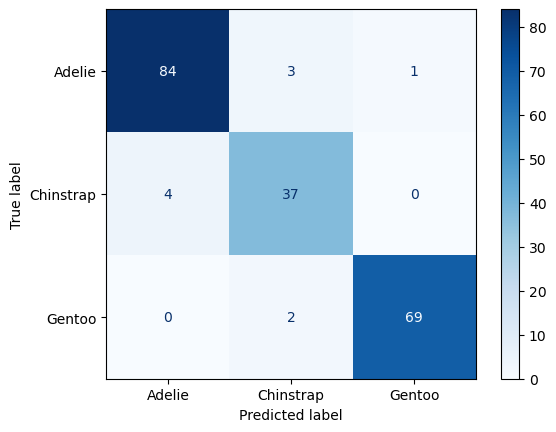

In [55]:
evaluate('40/60')

#### b. 60/40 Splitting

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        59
           1       0.90      0.96      0.93        27
           2       1.00      0.98      0.99        48

    accuracy                           0.96       134
   macro avg       0.95      0.96      0.96       134
weighted avg       0.96      0.96      0.96       134



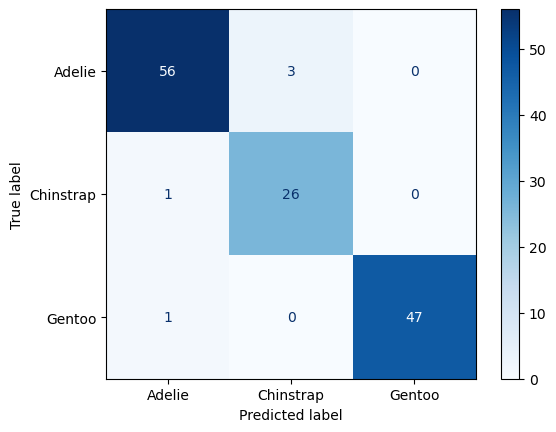

In [56]:
evaluate('60/40')

#### c. 80/20 Splitting

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        29
           1       1.00      0.93      0.96        14
           2       1.00      1.00      1.00        24

    accuracy                           0.99        67
   macro avg       0.99      0.98      0.98        67
weighted avg       0.99      0.99      0.98        67



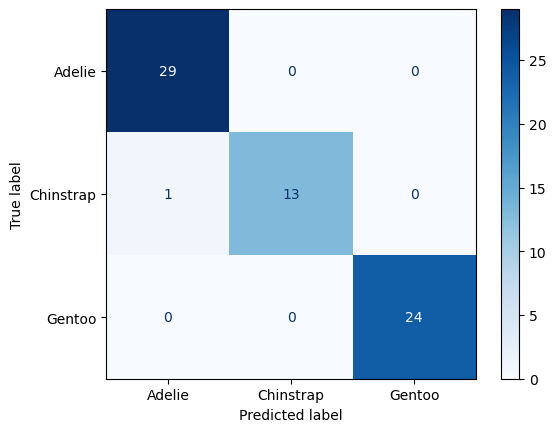

In [57]:
evaluate('80/20')

#### d. 90/10 Splitting

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00        12

    accuracy                           0.97        34
   macro avg       0.96      0.98      0.97        34
weighted avg       0.97      0.97      0.97        34



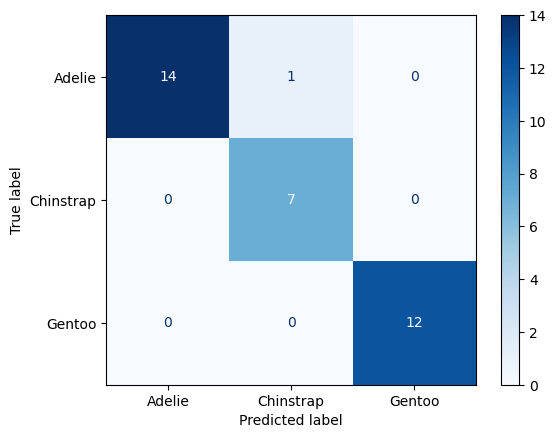

In [58]:
evaluate('90/10')